<a href="https://colab.research.google.com/github/Sungrebe/Smart-Bird-Feeder/blob/main/cc_backyard_bird_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# install astrapy and sentence_transformers (run this every time the runtime restarts)
!pip install astrapy
!pip install transformers

import os
from PIL import Image
from matplotlib import pyplot as plt
from astrapy import DataAPIClient
from transformers import CLIPProcessor, CLIPModel
from google.colab import drive, userdata, files

# load database and image collection

client = DataAPIClient(userdata.get('ASTRA_DB_APPLICATION_TOKEN'))
db = client.get_database(userdata.get('ASTRA_DB_API_ENDPOINT'))
col = db.get_collection("cc_backyard_birds")

# load CLIP model (Vit-B-32)

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# Helper method for the model to process image inputs
def process_image(image_path):
  input = processor(
    images=Image.open(image_path),
    return_tensors="pt"
  )
  return model.get_image_features(**input).flatten()

drive.mount('/content/drive')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.1/177.1 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 34.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.6/313.6 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 4.5 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

Mounted at /content/drive


In [6]:
# Hash table with select bird species (only 11 for testing purposes)
# and their image folders from the nabirds dataset
# in the final version we will have at least 100 species
species = {
    "Mourning Dove": ["0529"],
    "Red-bellied Woodpecker": ["0553"],
    "Blue Jay": ["0950"],
    "Black-capped Chickadee": ["0812"],
    "Tufted Titmouse": ["0819"],
    "European Starling": ["0748", "0856", "1005"],
    "American Robin": ["0753", "0960"],
    "House Finch": ["0790", "0997"],
    "American Goldfinch": ["0794", "1001"],
    "Common Grackle": ["0912"],
    "Northern Cardinal": ["0772", "0979"],
}

"""
# load cc_backyard_birds images into dataset

nabirds_dir = "/content/drive/MyDrive/nabirds/"

for species_name, species_folders in species.items():
  for folder in species_folders:
    for img_file in os.listdir(nabirds_dir + folder):
      # convert each image into a vector representation using CLIP model
      img_vector = process_image(nabirds_dir + folder + "/" + img_file)

      col.insert_one({
          "text": species_name,
          "$vector": img_vector.tolist(),
      })
"""

'\n# load cc_backyard_birds images into dataset\n\nnabirds_dir = "/content/drive/MyDrive/nabirds/"\n\nfor species_name, species_folders in species.items():\n  for folder in species_folders:\n    for img_file in os.listdir(nabirds_dir + folder):\n      # convert each image into a vector representation using CLIP model\n      img_vector = process_image(nabirds_dir + folder + "/" + img_file)\n\n      col.insert_one({\n          "text": species_name,\n          "$vector": img_vector.tolist(),\n      })\n'

In [15]:
# TODO: implement fine-tuning algorithm
import random
import os
import re
import torch
import torch.nn.functional as F
from torch.optim import AdamW
import shutil

# We will use triplet loss

# Basic idea is that for each species, we create a set of triplets
# Each triplet consists of three images - an anchor, positive, and negative
# The anchor image is an image of the species, the positive another
# image of that species, and the negative an image of an unrelated but
# easily confused species (from the perspective of the model)

# 1. Create a dataset of triplets (~10 for each species to start with)
# For each triplet, it will be saved in the following order:
# the name of the bird species, then the image ID of the anchor
# the image ID of the positive, and the image ID of the negative

nabirds_dir = "/content/drive/MyDrive/nabirds/"

async def create_triplets():
  for species_name, species_folder in species.items():
    anchors = random.sample(os.listdir(nabirds_dir + species_folder[0] + "/"), 10)

    for i in range(len(anchors)):
      shutil.copy2(nabirds_dir + species_folder[0] + "/" + anchors[i], nabirds_dir + f"triplets/{species_name}/" + f"{i}_anchor" + ".jpg")

      # get top results for each anchor image
      results = await search_img(nabirds_dir + f"triplets/{species_name}/" + f"{i}_anchor" + ".jpg")
      results_list = list(results)

      for result in results_list:
        print(result['text'], result['$similarity'], result['_id'])

      # lowest ranking correct result is pos, highest ranking incorrect result is neg
      lowest_pos = list(filter(lambda x: x['text'] == species_name, reversed(results_list)))[0]
      all_negatives = list(filter(lambda x: x['text'] != species_name, results_list))

      if all_negatives != []:
        highest_neg = all_negatives[0]

      pos_id = lowest_pos['_id']
      neg_id = highest_neg['_id']
      neg_species = highest_neg['text']

      # find file path of pos and neg images
      pos_img_path = nabirds_dir + species_folder[0] + "/" + pos_id
      neg_img_path = nabirds_dir + species[neg_species][0] + "/" + neg_id

      shutil.copy2(pos_img_path, nabirds_dir + "triplets/" + species_name + "/" + f"{i}_pos" + ".jpg")
      shutil.copy2(neg_img_path, nabirds_dir + "triplets/" + species_name + "/" + f"{i}_neg" + ".jpg")

# 2. Split dataset into training, test, and validation
# create subdirectories within the triplets folder containing those triplets
# for training, test, and validation respectively

def split_dataset():
  # code goes here
  for species_name, species_folder in species.items():
    file_path = "/content/drive/MyDrive/nabirds/triplets/"
    file_path += species_name
    file_path += "/"

    random_number = random.randint(0, 9)
    if os.path.exists(file_path):
      os.makedirs(file_path + "train")
      os.makedirs(file_path + "test")
      os.makedirs(file_path + "validation")
      for i in range(10):
        random_number = (random_number + 1) % 10
        if i < 8:
          shutil.move(file_path + f"{i}_pos.jpg", file_path + "train/" + f"{i}_pos.jpg")
          shutil.move(file_path + f"{i}_neg.jpg", file_path + "train/" + f"{i}_neg.jpg")
          shutil.move(file_path + f"{i}_anchor.jpg", file_path + "train/" + f"{i}_anchor.jpg")
        if i == 8:
          shutil.move(file_path + f"{i}_pos.jpg", file_path + "test/" + f"{i}_pos.jpg")
          shutil.move(file_path + f"{i}_neg.jpg", file_path + "test/" + f"{i}_neg.jpg")
          shutil.move(file_path + f"{i}_anchor.jpg", file_path + "test/" + f"{i}_anchor.jpg")
        if i > 8:
          shutil.move(file_path + f"{i}_pos.jpg", file_path + "validation/" + f"{i}_pos.jpg")
          shutil.move(file_path + f"{i}_neg.jpg", file_path + "validation/" + f"{i}_neg.jpg")
          shutil.move(file_path + f"{i}_anchor.jpg", file_path + "validation/" + f"{i}_anchor.jpg")
    else:
      print(f"The file '{file_path}' does not exist.")


#split_dataset()

# 3. Define triplet loss function

margin = 1.0

def triplet_loss():
  # code goes here
  tloss_species = {}
  for species_name, species_folder in species.items():
    file_path = "/content/drive/MyDrive/nabirds/triplets/"
    file_path += species_name
    file_path += "/train/"
    total_loss = 0
    for i in range(8):
      if (os.path.exists(file_path + f"{i}_pos.jpg")):
        anchor = process_image(file_path + f"{i}_anchor.jpg")
        positive = process_image(file_path + f"{i}_pos.jpg")
        negative = process_image(file_path + f"{i}_neg.jpg")

        pos_distance = F.pairwise_distance(anchor, positive, p=2)
        neg_distance = F.pairwise_distance(anchor, negative, p=2)

        loss = torch.clamp(pos_distance - neg_distance + margin, min=0.0)
        total_loss += loss
    tloss_species[species_name] = total_loss.item() / 8
    file_path = os.path.join(file_path, 'loss.txt')
    with open(file_path, 'w') as f:
      f.write(str(total_loss.item() / 8))
  return tloss_species

#triplet_loss = triplet_loss()
#print(triplet_loss)

def triplet_loss_per_species(species):
  file_path = "/content/drive/MyDrive/nabirds/triplets/"
  file_path += species
  file_path += "/train/"
  total_loss = 0
  for i in range(8):
    if (os.path.exists(file_path + f"{i}_pos.jpg")):
      anchor = process_image(file_path + f"{i}_pos.jpg")
      positive = process_image(file_path + f"{i}_pos.jpg")
      negative = process_image(file_path + f"{i}_neg.jpg")
      pos_distance = F.pairwise_distance(anchor, positive, p=2)
      neg_distance = F.pairwise_distance(anchor, negative, p=2)

      loss = torch.clamp(pos_distance - neg_distance + margin, min=0.0)
      total_loss += loss
  return total_loss.item() / 8

def triplet_loss_per_species_triplet(species, triplet):
  file_path = "/content/drive/MyDrive/nabirds/triplets/"
  file_path += species
  file_path += "/train/"
  if (os.path.exists(file_path + f"{triplet}_pos.jpg")):
    anchor = process_image(file_path + f"{triplet}_pos.jpg")
    positive = process_image(file_path + f"{triplet}_pos.jpg")
    negative = process_image(file_path + f"{triplet}_neg.jpg")
    pos_distance = F.pairwise_distance(anchor, positive, p=2)
    neg_distance = F.pairwise_distance(anchor, negative, p=2)

    loss = torch.clamp(pos_distance - neg_distance + margin, min=0.0)
    return loss

# 4. Write a training loop
  # - Compute predicted outputs
  # - Get loss for each step
  # - Perform optimization
  # - Get val accuracy after each step
def optimize():
  #train_dataloader = torch.utils.data.DataLoader(triplets, batch_size=64, shuffle=True)
  optimizer = AdamW(model.parameters(), lr=5e-5, betas=(0.9,0.98), eps=1e-6, weight_decay=0.2)
  # loss = triplet_loss_per_species(species) #F.CrossEntropyLoss()

  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  if device == "cpu":
    model.float()

  # After the first epoch, the positives and negatives may not be fully accurate, since they are not updated
  epochs = 1
  for epoch in range(epochs):
    # go through each triplet in the training data
    for species_name, species_folder in species.items():
      for i in range(8):
        optimizer.zero_grad()

        #compute loss
        loss = triplet_loss_per_species_triplet(species_name, i)

        #Backward pass
        loss.backward()
        optimizer.step()
  return optimizer


# 5. Save a copy of the fine tuned model
model = optimize()
# 6. Create a new collection of images using the fine tuned model and
# perform image searches using that collection

"""
# 2. Split dataset into training, test, and validation
async def split_dataset(triplets):
  training_triplets = []
  test_triplets = []
  validation_triplets = []
  i = 0
  for triplet in triplets:
    if (i % 10 < 8):
      training_triplets.append(triplet)
    elif (i % 10 == 8):
      test_triplets.append(triplet)
    else:
      validation_triplets.append(triplet)
    i += 1
  return training_triplets, test_triplets, validation_triplets

training_triplets, test_triplets, validation_triplets = await split_dataset(triplets)

# 3. Define triplet loss function
# Torch import at the top

def triplet_loss(anchor, positive, negative, margin=1.0):
    """
"""
    Compute the triplet loss according to the formula:
    Loss = max(d(A, P) - d(A, N) + margin, 0)

    Parameters:
    - anchor: address for anchor, needs to be converted to tensor of shape (batch_size, embedding_dim) for the anchor examples
    - positive: address for positive, needs to be converted to tensor of shape (batch_size, embedding_dim) for the positive examples
    - negative: address for negative, needs to be converted to tensor of shape (batch_size, embedding_dim) for the negative examples
    - margin: Float, the margin for triplet loss

    Returns:
    - loss: Scalar, the computed triplet loss

    anchor_tensor = process_image(nabirds_dir + "/" + anchor)
    positive_tensor = process_image(nabirds_dir + "/" + positive)
    negative_tensor = process_image(nabirds_dir + "/" + negative)
    # Compute the pairwise distances
    pos_distance = F.pairwise_distance(anchor_tensor, positive_tensor, p=2)
    neg_distance = F.pairwise_distance(anchor_tensor, negative_tensor, p=2)

    # Compute the triplet loss
    loss = torch.clamp(pos_distance - neg_distance + margin, min=0.0)

    # Return the mean loss over the batch
    return loss.mean()

for triplet in training_triplets:
  print(triplet)
  print(triplet_loss(triplet[1], triplet[2], triplet[3]))
"""

'\n    Compute the triplet loss according to the formula:\n    Loss = max(d(A, P) - d(A, N) + margin, 0)\n\n    Parameters:\n    - anchor: address for anchor, needs to be converted to tensor of shape (batch_size, embedding_dim) for the anchor examples\n    - positive: address for positive, needs to be converted to tensor of shape (batch_size, embedding_dim) for the positive examples\n    - negative: address for negative, needs to be converted to tensor of shape (batch_size, embedding_dim) for the negative examples\n    - margin: Float, the margin for triplet loss\n\n    Returns:\n    - loss: Scalar, the computed triplet loss\n\n    anchor_tensor = process_image(nabirds_dir + "/" + anchor)\n    positive_tensor = process_image(nabirds_dir + "/" + positive)\n    negative_tensor = process_image(nabirds_dir + "/" + negative)\n    # Compute the pairwise distances\n    pos_distance = F.pairwise_distance(anchor_tensor, positive_tensor, p=2)\n    neg_distance = F.pairwise_distance(anchor_tensor

Saving 413802271.jpg to 413802271.jpg


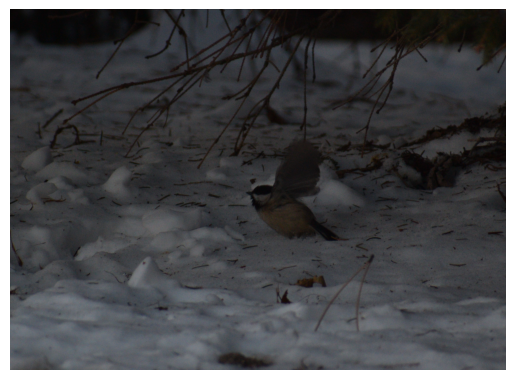

Black-capped Chickadee 0.9252002
Black-capped Chickadee 0.91909844
Blue Jay 0.9174031
Blue Jay 0.9027488
European Starling 0.9027454
Tufted Titmouse 0.9024339
House Finch 0.89994574
Black-capped Chickadee 0.89974546
Blue Jay 0.8993108
Blue Jay 0.89871776
Northern Cardinal 0.89832556
House Finch 0.89801955
Northern Cardinal 0.8976977
Tufted Titmouse 0.8971392
Black-capped Chickadee 0.8962946
Northern Cardinal 0.8957068
Northern Cardinal 0.8955924
House Finch 0.8937539
Black-capped Chickadee 0.8922131
Tufted Titmouse 0.8908469
Northern Cardinal 0.89064157
Northern Cardinal 0.8905942
Tufted Titmouse 0.89055955
Mourning Dove 0.89022136
House Finch 0.88753116
Northern Cardinal 0.88725466
European Starling 0.88663423
Mourning Dove 0.8864746
European Starling 0.8860767
Northern Cardinal 0.88569117


In [5]:
# method for searching database
# returns top 15 most similar images given a specific image

async def search_img(image_path):
  searching_vector = process_image(image_path).tolist()
  most_similar_imgs = col.find(
      sort={"$vector": searching_vector},
      limit=30,
      include_similarity=True,
  )

  return most_similar_imgs

# demo code, loads a user inputted image and classifies it using the search_img method

images = files.upload()
input_path = next(iter(images))

plt.imshow(Image.open(input_path))
plt.axis("off")
plt.show()

results = await search_img(input_path)

for result in results:
  print(result['text'], result['$similarity'])